In [2]:
!pip install qulacs
!pip install qulacsvis
!pip install matplotlib
!pip install numpy
!pip install scipy

Reshimming asdf python...
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 688.2/688.2 kB 8.6 MB/s eta 0:00:00m eta 0:00:010:01
Using legacy 'setup.py install' for temp, since package 'wheel' is not installed.
  Running setup.py install for temp ... done
  Attempting uninstall: Qulacs
    Found existing installation: Qulacs 0.3.1
    Uninstalling Qulacs-0.3.1:
      Successfully uninstalled Qulacs-0.3.1
Reshimming asdf python...
Reshimming asdf python...
Reshimming asdf python...
Reshimming asdf python...


In [91]:
import matplotlib.pyplot as plt
import numpy as np
from qulacs import Observable, QuantumState, PauliOperator, QuantumCircuit, ParametricQuantumCircuit, DensityMatrix
from qulacs.gate import  Identity,X, Y, H, Z, S, Sdag, DepolarizingNoise, DephasingNoise, AmplitudeDampingNoise, TwoQubitDepolarizingNoise

In [92]:
#１次元横磁場イジング模型のハミルトニアンを定義
n_qubits = 4
transverse_Ising_hamiltonian = Observable(n_qubits)
J = 1.0
h = 1.0
for i in range(n_qubits):
    if i == n_qubits - 1:
        continue
    transverse_Ising_hamiltonian.add_operator(J, f"Z {i} Z {(i+1)%n_qubits}")
    transverse_Ising_hamiltonian.add_operator(h, f"X {i}")

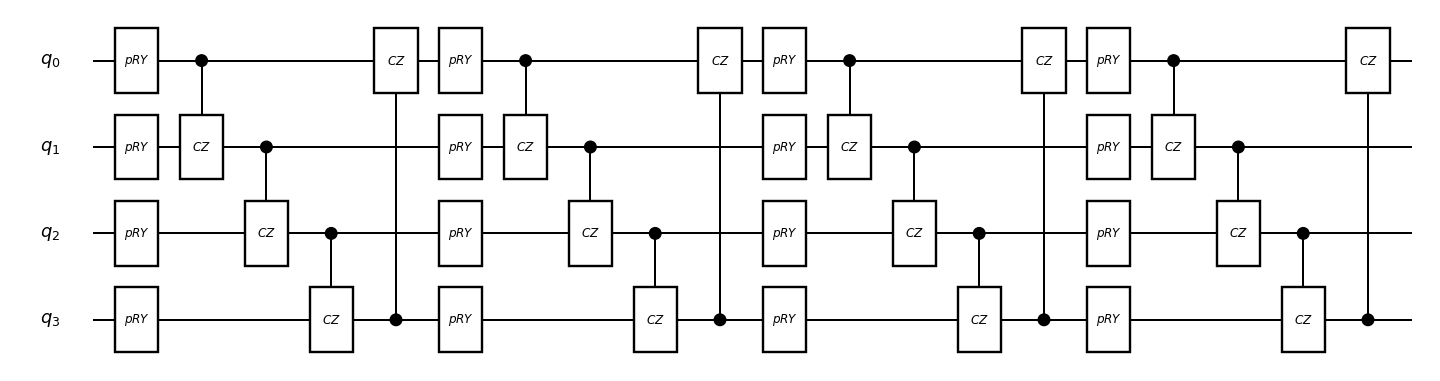

In [93]:
## まずはエラーなしの場合
from qulacsvis import circuit_drawer
from scipy.optimize import minimize

#状態ベクトル、ansatz回路を定義
n_qubits = 4
state = QuantumState(n_qubits)
circuit_depth = 4
circuit = ParametricQuantumCircuit(n_qubits)

#ansatz回路を指定
def Circuit(n_qubits,circuit_depth):
    circuit = ParametricQuantumCircuit(n_qubits)
    for d in range(circuit_depth):
        for i in range(n_qubits):
            circuit.add_parametric_RY_gate(i, 0.0)
        for i in range(n_qubits):
            circuit.add_CZ_gate(i, (i+1)%n_qubits)
    return circuit
circuit = Circuit(n_qubits,circuit_depth)
params = np.zeros(circuit.get_parameter_count())

#ansatz回路を表示
circuit_drawer(circuit, "mpl")

In [94]:
def get_cost(params):
    state = QuantumState(n_qubits)
    for i, p in enumerate(params):
        circuit.set_parameter(i,p)
    circuit.update_quantum_state(state)
    return transverse_Ising_hamiltonian.get_expectation_value(state)

In [95]:
#上で定義したansatz回路のもとで、コスト関数を最小化する。
params_initial = np.zeros_like(params)
minimized_costfunction = minimize(get_cost, params_initial, options={'maxiter':50, "gtol": 1e-6}, method='BFGS')

#コスト関数の最小値を表示
print(minimized_costfunction.fun)

-4.026207469740617


In [96]:
params_true = minimized_costfunction.x

In [97]:
## 次にdepolarizing noiseありの場合（１次元横磁場イジング模型）

#密度演算子、ansatz回路を定義
density_state = DensityMatrix(n_qubits)
noisy_circuit = ParametricQuantumCircuit(n_qubits)
error_rate = 0.01

#ansatz回路を指定
def NoisyCircuit(error_rate):
    noisy_circuit = ParametricQuantumCircuit(n_qubits)
    for d in range(circuit_depth):
        for i in range(n_qubits):
            noisy_circuit.add_parametric_RY_gate(i, 0.0)
            noisy_circuit.add_gate(DepolarizingNoise(i, error_rate))
        for i in range(n_qubits):
            noisy_circuit.add_CZ_gate(i, (i+1)%n_qubits)
            noisy_circuit.add_gate(DepolarizingNoise(i, error_rate))
            noisy_circuit.add_gate(DepolarizingNoise((i+1)%n_qubits, error_rate))
    return noisy_circuit

noisy_circuit = NoisyCircuit(error_rate)

In [98]:
#コスト関数を定義。ここではエネルギー期待値がコスト関数。
def noisy_get_cost(params):
    density_state = DensityMatrix(n_qubits)
    for i, p in enumerate(params):
        noisy_circuit.set_parameter(i,p)
    noisy_circuit.update_quantum_state(density_state)
    return transverse_Ising_hamiltonian.get_expectation_value(density_state)

In [99]:
#エラーなし、エラーありの場合で期待値を計算
minimized_costfunction_noiseless = get_cost(params_true)
minimized_costfunction_noise = noisy_get_cost(params_true)

#コスト関数の最小値を表示
print(minimized_costfunction_noiseless)
print(minimized_costfunction_noise)

-4.026207469740617
-2.8715447717199116


In [100]:
def get_cost_sampling(shots,params):
    density_state = DensityMatrix(n_qubits)
    noisy_circuit = NoisyCircuit(error_rate)
    for i, p in enumerate(params):
        noisy_circuit.set_parameter(i,p)
    noisy_circuit.update_quantum_state(density_state)
    density_copy_ZZ = DensityMatrix(n_qubits)
    density_copy_X = DensityMatrix(n_qubits)
    density_copy_ZZ = density_state.copy()
    density_copy_X = density_state.copy()
    mask_list_ZZ = [0b1100,0b0110,0b0011,0b1001]
    mask_list_X = [0b1000,0b0100,0b0010,0b0001]
    for i in range(n_qubits):
        gate = H(i)
        gate.update_quantum_state(density_copy_X)
    noise_sampling_ZZ = density_copy_ZZ.sampling(shots)
    noise_sampling_X = density_copy_X.sampling(shots)
    estimated_ZZ_average = 0.0
    estimated_X_average = 0.0
    for s in noise_sampling_ZZ:
        for mask in mask_list_ZZ:
            bitcount = bin(s & mask).count("1")
            estimated_ZZ_average += (-1)**bitcount/shots
    for s in noise_sampling_X:
        for mask in mask_list_X:
            bitcount = bin(s & mask).count("1")
            estimated_X_average += (-1)**bitcount/shots
    data_sampling_average = h * estimated_X_average + J * estimated_ZZ_average
    return data_sampling_average

In [101]:
#エラー率を固定して、ヒストグラムを作成
error_rate = 0.01
n_test = 300
shots = 1000
no_mitigation_list = np.zeros(n_test)

for i in range(n_test):
    density_state = DensityMatrix(n_qubits)
    noisy_circuit = NoisyCircuit(error_rate)
    no_mitigation_list[i] = get_cost_sampling(shots,params_true)
expec_value = noisy_get_cost(params_true)



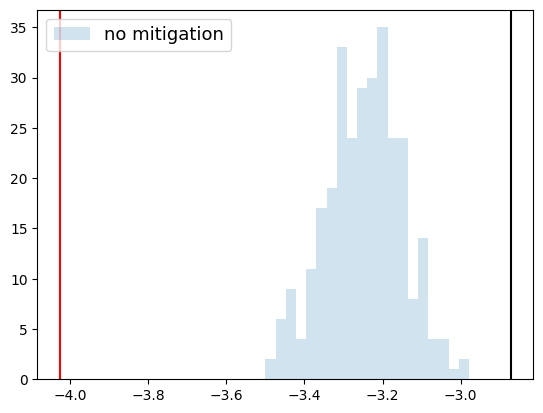

In [102]:
plt.hist(no_mitigation_list, alpha=0.2, bins=20, label=f"no mitigation")
plt.axvline(expec_value, color="black")
plt.axvline(get_cost(params_true), color="red")
plt.legend(loc="upper left", fontsize=13)
plt.show()